<a href="https://colab.research.google.com/github/chasubeen/BLIP4Fashion/blob/%EC%88%98%EB%B9%88/preprocessing_%EC%B0%A8%EC%88%98%EB%B9%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import requests
import matplotlib.pyplot as plt
import random

from PIL import Image
from io import BytesIO

# **0. 원본 파일 불러오기**

In [ ]:
# Google Drive 연결

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_file = '/content/drive/MyDrive/Euron/6th-project_personal/meta_all_129927.json'

In [ ]:
# json 데이터 로드

with open(input_file, 'r') as f:
  data = json.load(f)

In [ ]:
data[3]

{'id': 127712,
 'images': [{'color': 'Anthracite Leather',
   '0': 'https://n.nordstrommedia.com/id/sr3/042372f2-ad61-4c13-bf9a-e562559b1ee2.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
   '1': 'https://n.nordstrommedia.com/id/sr3/2f9817d7-78f1-4310-b0c5-0a754b6dcb97.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
   '2': 'https://n.nordstrommedia.com/id/sr3/9ed2d98f-700c-450e-aea2-9fdecb917478.jpeg',
   '3': 'https://n.nordstrommedia.com/id/sr3/c3d6335c-a0da-4860-8181-76c9596ade68.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
   '4': 'https://n.nordstrommedia.com/id/sr3/8e5a5d36-4f21-425c-bbc9-a94f52057101.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
   '5': 'https://n.nordstrommedia.com/id/sr3/b9ebb4ac-be98-437b-9e98-aa43c2112856.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
   '6': 'https://n.nordstrommedia.com/id/sr3/5845f373-4c4

In [ ]:
data[3]['images'][0]

{'color': 'Anthracite Leather',
 '0': 'https://n.nordstrommedia.com/id/sr3/042372f2-ad61-4c13-bf9a-e562559b1ee2.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
 '1': 'https://n.nordstrommedia.com/id/sr3/2f9817d7-78f1-4310-b0c5-0a754b6dcb97.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
 '2': 'https://n.nordstrommedia.com/id/sr3/9ed2d98f-700c-450e-aea2-9fdecb917478.jpeg',
 '3': 'https://n.nordstrommedia.com/id/sr3/c3d6335c-a0da-4860-8181-76c9596ade68.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
 '4': 'https://n.nordstrommedia.com/id/sr3/8e5a5d36-4f21-425c-bbc9-a94f52057101.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
 '5': 'https://n.nordstrommedia.com/id/sr3/b9ebb4ac-be98-437b-9e98-aa43c2112856.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90',
 '6': 'https://n.nordstrommedia.com/id/sr3/5845f373-4c4c-4561-b75b-7df874c4afec.jpeg?crop=pad&pa

In [ ]:
data[3]['images'][0]['0']

'https://n.nordstrommedia.com/id/sr3/042372f2-ad61-4c13-bf9a-e562559b1ee2.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90'

In [ ]:
len(data) # 전체 126753개의 데이터

126753

# **1. 데이터 전처리**

**(7/26 10:39 기준)**  
- 데이터 처리되는 속도를 가지고 대충 계산해보니 하루 이상은 돌려야겠더라고요..ㅋㅋㅋ쿠ㅜ
  - 근데 코랩 무료는 12시간이면 끊기고, 프로여도 24시간이면 끊기니..
  - 이거 하자고 프로 결제하기엔 매우매우매우 아까움..(프로는 모델링 할 때 써요..)
- 코드 분리해서 train/val/test 나눠서 받을 수 있도록 수정했습니다.
  - train의 경우 로컬로 돌릴게요.(데탑으로 돌려두면 돼요 ㅎㅅㅎ)

In [ ]:
### ID를 할당하는 함수

def assign_ids(images, annotations):
  for i, (img, ann) in enumerate(zip(images, annotations), start=1):
    img['id'] = i
    ann['image_id'] = i
    ann['id'] = i

In [ ]:
### COCO 형식의 annotation 파일을 생성하는 함수

def create_coco_format(images, annotations):
  return {
      "images": images,
      "annotations": annotations,
      "info": {
          "description": "Custom COCO Dataset",
          "version": "1.0",
          "year": 2024
      },
      "licenses": []
  }

In [ ]:
### 데이터셋 분리
# train, val, test로 나누기(8:0.5:1.5)

def split_dataset(data, train_ratio = 0.8, val_ratio = 0.05):
  total_length = len(data)

  train_end = int(total_length * train_ratio)
  val_end = train_end + int(total_length * val_ratio)

  train_data = data[:train_end]
  val_data = data[train_end:val_end]
  test_data = data[val_end:]

  return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = split_dataset(data)

In [ ]:
len(train_data)

101402

In [ ]:
# 파일 개수 조정

train_data = train_data[:50000]
len(train_data)

50000

In [ ]:
len(test_data)

19014

In [ ]:
# 파일 개수 조정

test_data = test_data[:13000]
len(test_data)

13000

In [ ]:
### 데이터 로드 및 전처리

def preprocess_data(data, output_dir, dataset_type):
  ## 폴더 생성
  dataset_dir = os.path.join(output_dir, dataset_type)
  os.makedirs(dataset_dir, exist_ok = True)

  ## 이미지 다운로드 및 저장
  images_metadata = []
  annotations = []

  for item in data:
    description = item['description']

    ## 첫 번째 색상의 첫 번째 이미지 사용
    if item['images']:
      first_image_info = item['images'][0] # 첫 번째 색상
      image_url = first_image_info.get('0')  # '0' 키의 값을 가져옴(첫 번째 사진)

      if image_url:
        try:
          # 이미지 다운로드
          response = requests.get(image_url)
          response.raise_for_status()  # 요청이 성공했는지 확인

          img = Image.open(BytesIO(response.content))
          img_filename = f'image_{len(images_metadata) + 1}.jpg'
          img.save(os.path.join(dataset_dir, img_filename))

          # 이미지 메타데이터 저장
          images_metadata.append({
              "file_name": img_filename
          })

          # 캡션 메타데이터 저장
          annotations.append({
              "caption": description
          })

        except requests.exceptions.RequestException as e:
          print(f"이미지 다운로드 실패: {image_url}")
          continue


  ## ID 재설정
  assign_ids(images_metadata, annotations)


  ## COCO 형식의 딕셔너리 생성
  coco_format = create_coco_format(images_metadata, annotations)


  ## COCO 형식의 JSON 파일 저장
  with open(os.path.join(output_dir, f'coco_{dataset_type}.json'), 'w') as f:
    json.dump(coco_format, f)

In [ ]:
output_dir = '/content/drive/MyDrive/Euron/6th-project_personal/data'

In [ ]:
preprocess_data(train_data, output_dir, 'train')

이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/4282bdb9-dc97-4335-8abf-d5958fe85ef8.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/085101e3-2c2f-4c5e-bbd8-34df42a86982.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/c5a219fb-3299-4dd5-8315-48047b004fd8.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/19e5866e-8323-49c0-ae3c-1fb9b1c486b2.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/4c5df21e-e42c-40a5-9562-eb3da71db935.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/a0d27d83-de96-4e33-ace1-d5b8bc3b156c.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/21b33a64-e7d1-4ecd-a33d-d9cfde85d912.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=col

In [ ]:
preprocess_data(val_data, output_dir, 'val')

이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/e404102a-f8b2-456b-b8ba-eda80fd15f76.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/a31bdc79-ffdc-4f30-966a-8a8c259e4d7d.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/b6d1ae44-ef48-469b-a393-3c7db64f75dc.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/610589e7-a927-44b5-886b-1740347ed49e.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/093f30e2-a0d9-4a0e-b2d7-9df479554d15.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90


In [ ]:
preprocess_data(test_data, output_dir, 'test')

이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/2b09db7d-909d-4e32-9963-54360306a321.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/83553943-fd4d-4375-b439-4de309017753.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/feda7d38-b7e9-4d8d-9555-0ca49cdd8cc8.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/cb434fb9-edf9-4fc8-a77b-4147c0dbf41a.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/dc304be8-1075-444e-a346-613c000b6a05.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/194affa1-1a1c-4ecf-8d32-842b80853c5b.jpeg?crop=pad&pad_color=FFF&format=jpeg&trim=color&trimcolor=FFF&w=60&h=90
이미지 다운로드 실패: https://o.nordstrommedia.com/id/sr3/96894abb-2

# **2. 결과 확인**

In [ ]:
### 데이터셋 개수 확인

def verify_dataset(output_dir, dataset_type):
  ## 데이터셋 경로
  dataset_dir = os.path.join(output_dir, dataset_type)


  ## 저장된 이미지 개수 확인
  num_images = len([f for f in os.listdir(dataset_dir) if f.endswith('.jpg')])
  print(f'저장된 {dataset_type} 이미지 개수: {num_images}')


  ## annotation 파일 내의 caption 수 확인
  annotation_path = os.path.join(output_dir, f'coco_{dataset_type}.json')
  with open(annotation_path, 'r') as f:
    coco_data = json.load(f)
  annotation_count = len(coco_data['annotations'])
  print(f'{dataset_type} 데이터의 caption 개수: {annotation_count}')

In [ ]:
verify_dataset(output_dir, 'train')

저장된 train 이미지 개수: 49950
train 데이터의 caption 개수: 49950


In [ ]:
verify_dataset(output_dir, 'val')

저장된 val 이미지 개수: 6332
val 데이터의 caption 개수: 6332


In [ ]:
verify_dataset(output_dir, 'test')

저장된 test 이미지 개수: 12987
test 데이터의 caption 개수: 12987


In [ ]:
### 샘플 확인

def visualize_samples(output_dir, dataset_type, num_samples = 5):
  ## COCO JSON 파일 로드
  coco_json_path = os.path.join(output_dir, f'coco_{dataset_type}.json')

  with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

  ## 샘플 출력
  # 랜덤하게 샘플 선택
  sample_indices = random.sample(range(len(coco_data['annotations'])), num_samples)

  for idx in sample_indices:
    annotation = coco_data['annotations'][idx]
    image_id = annotation['image_id']
    caption = annotation['caption']

    image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)

    if image_info:
      image_filename = image_info['file_name']
      image_path = os.path.join(output_dir, dataset_type, image_filename)

      # 이미지 시각화
      img = Image.open(image_path)
      plt.imshow(img)
      plt.title(caption)
      plt.axis('off')
      plt.show()

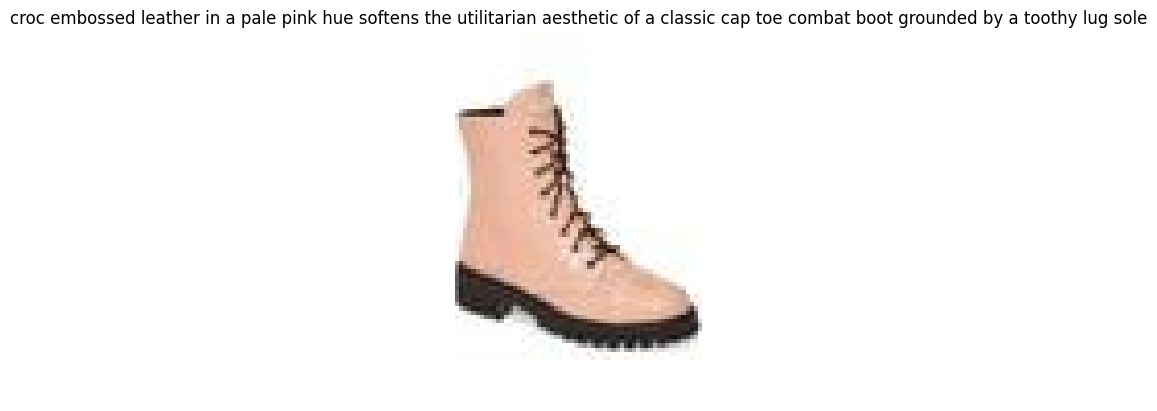

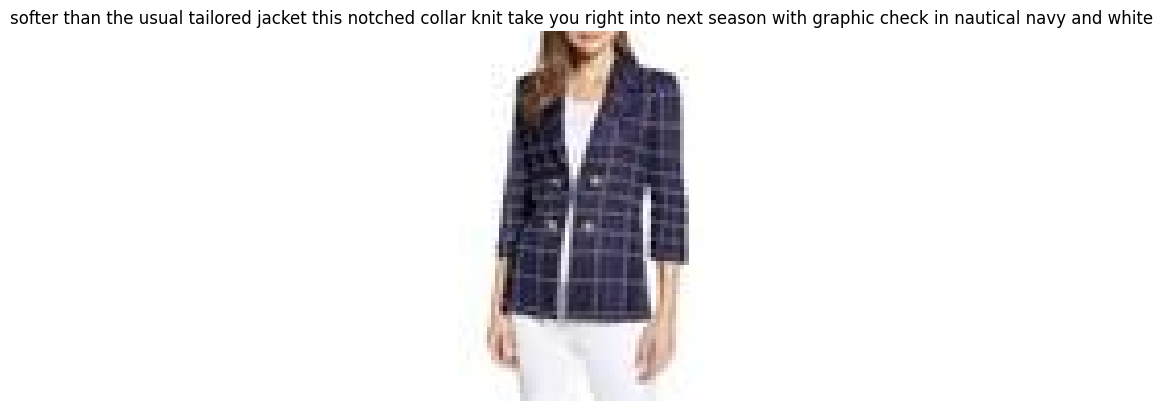

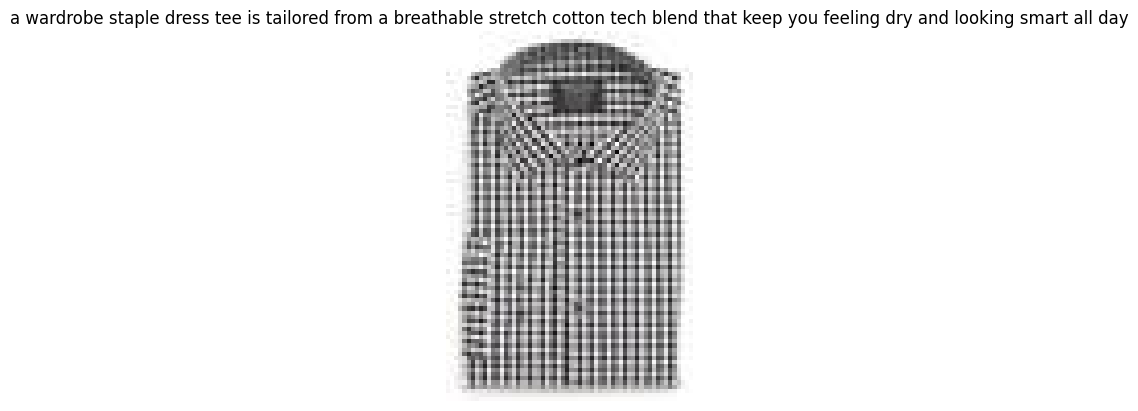

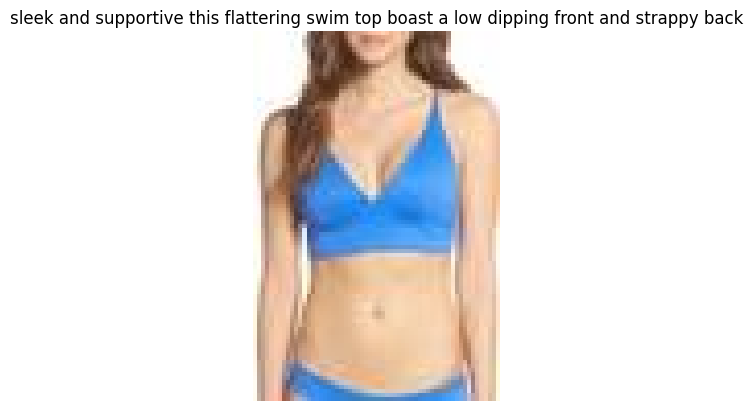

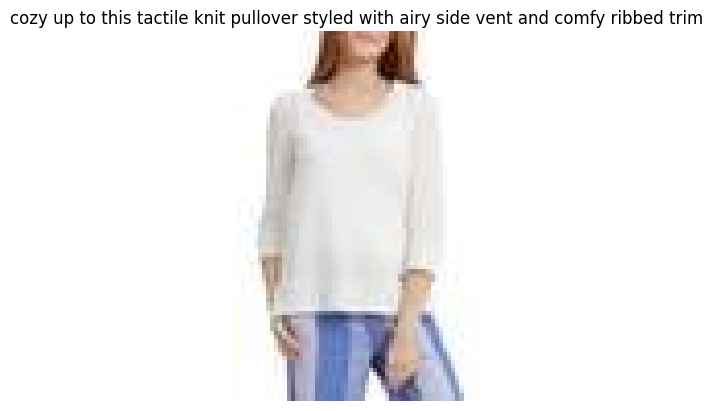

In [ ]:
visualize_samples(output_dir, 'train', num_samples = 5)

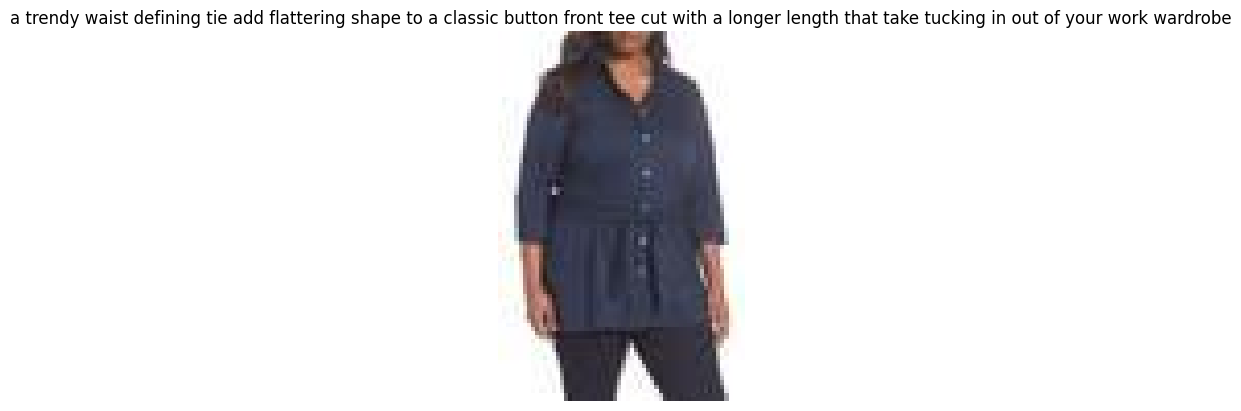

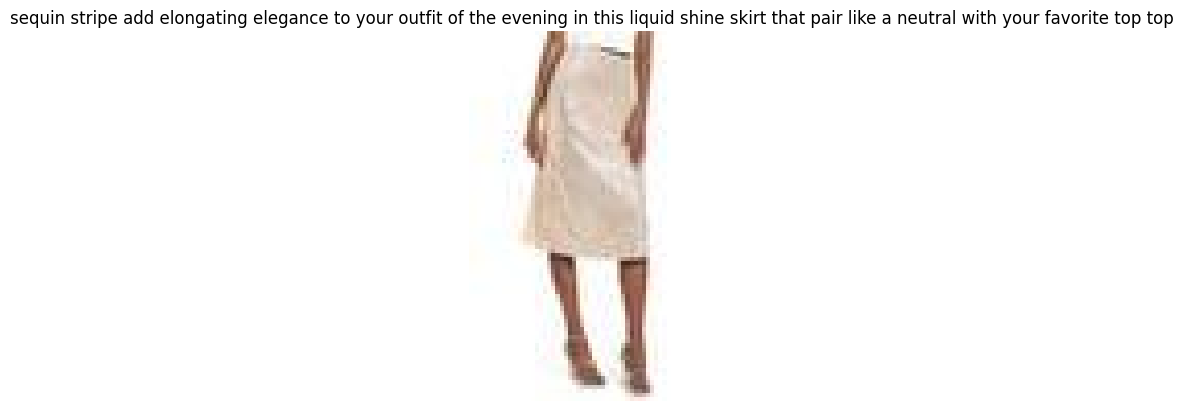

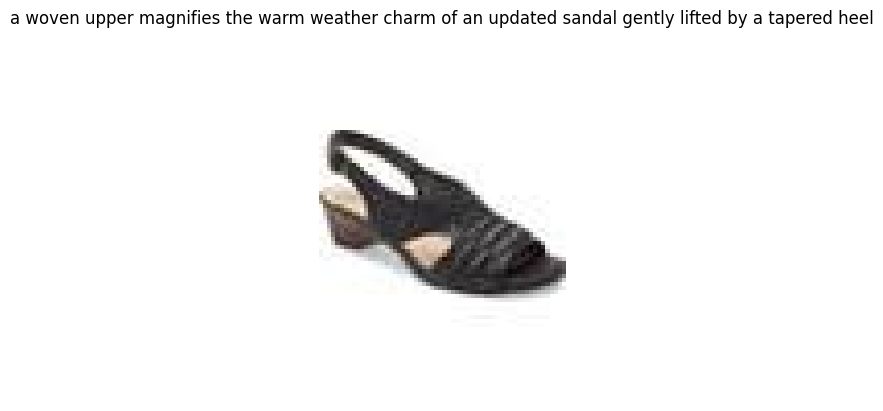

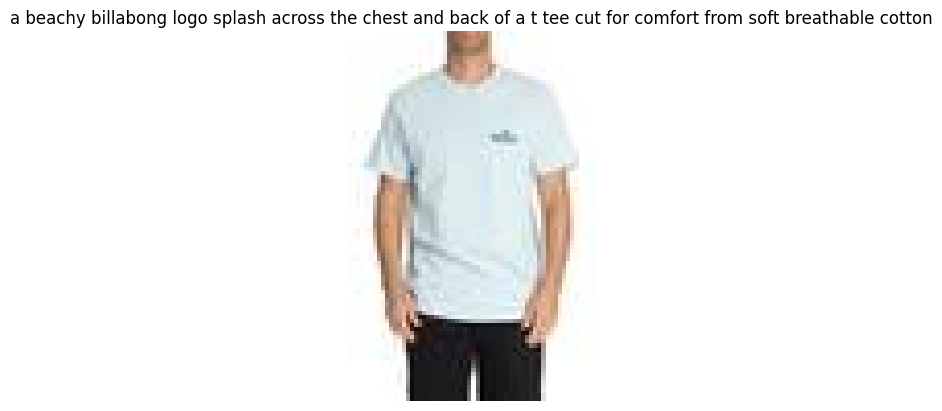

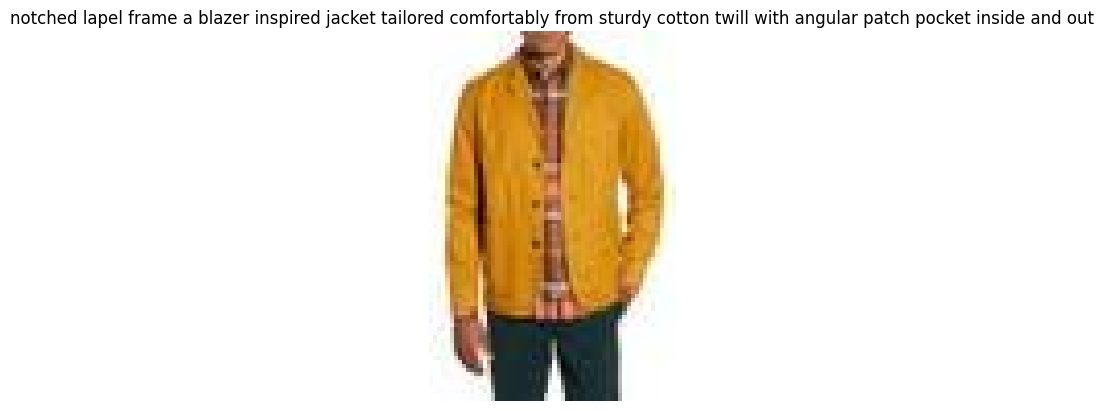

In [ ]:
visualize_samples(output_dir, 'val', num_samples = 5)

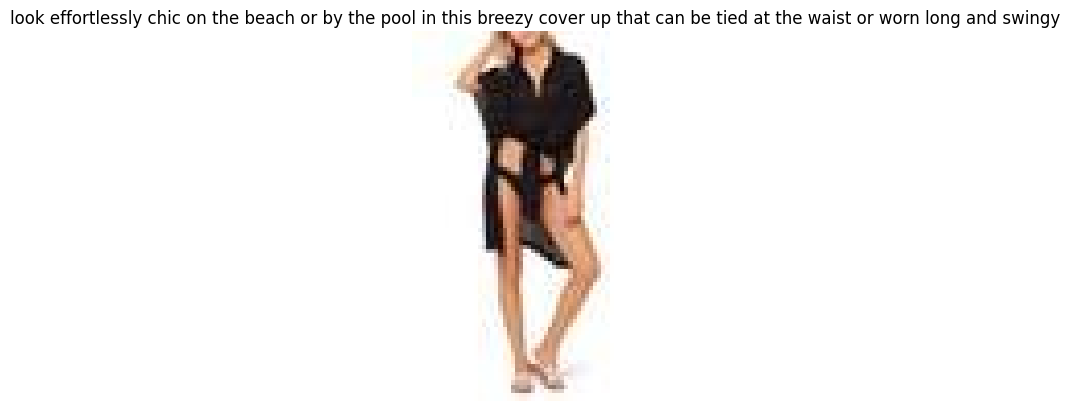

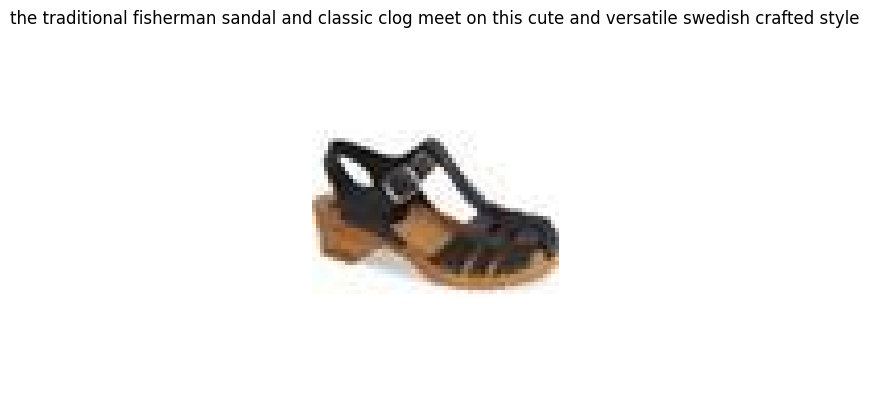

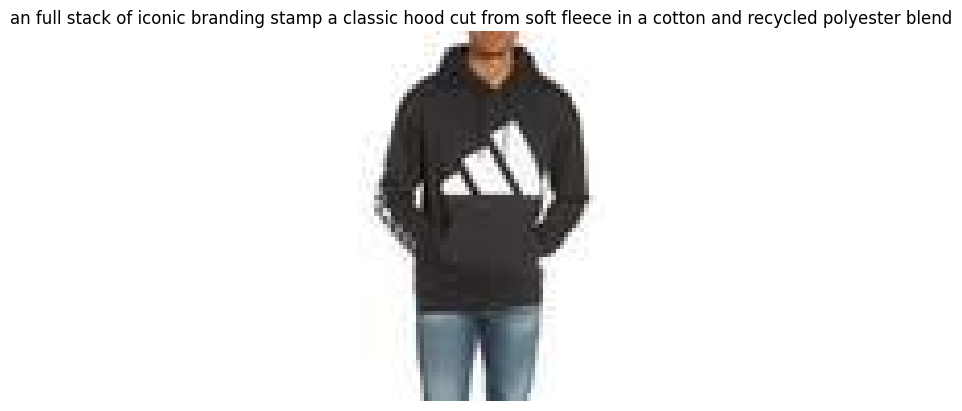

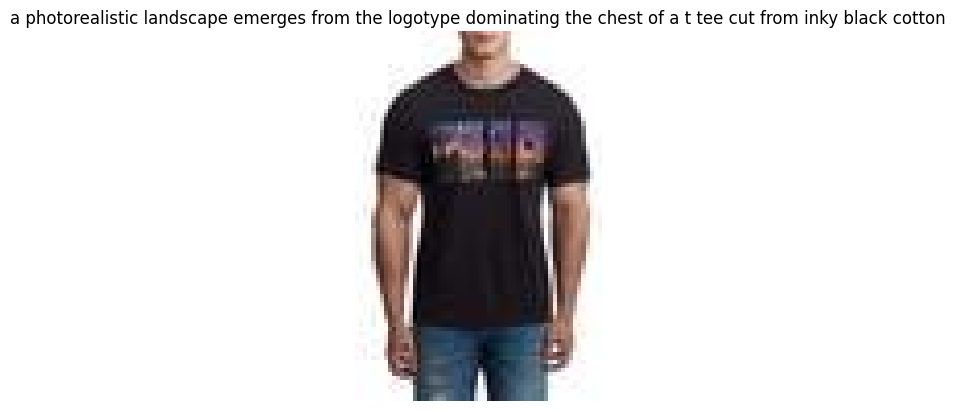

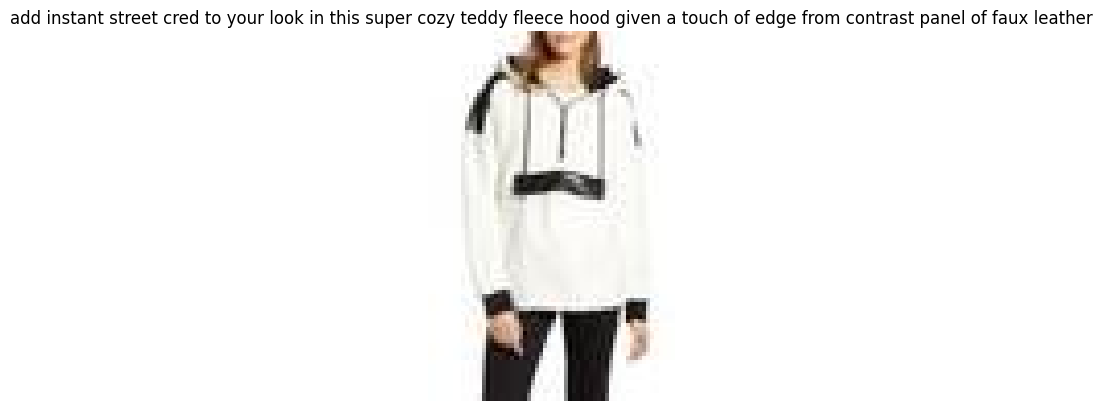

In [ ]:
visualize_samples(output_dir, 'test', num_samples = 5)